# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_n_snps_used_sharing_and_log"
    / "gls-1000g_mashr-sub_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-1000g_mashr-sub_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-1000g_mashr-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-1000g_mashr-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-1000g_mashr-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-1000g_mashr-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-1000g_mashr-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.008220,0.010706,-0.767824,0.442620,0.778690,random.pheno988
1,LV2,0.026426,0.012455,2.121685,0.033902,0.016951,random.pheno988
2,LV3,-0.009882,0.012317,-0.802282,0.422419,0.788790,random.pheno988
3,LV4,-0.016261,0.011930,-1.363033,0.172920,0.913540,random.pheno988
4,LV5,0.004536,0.012745,0.355927,0.721907,0.360953,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.06218338399189463

# QQ-plot

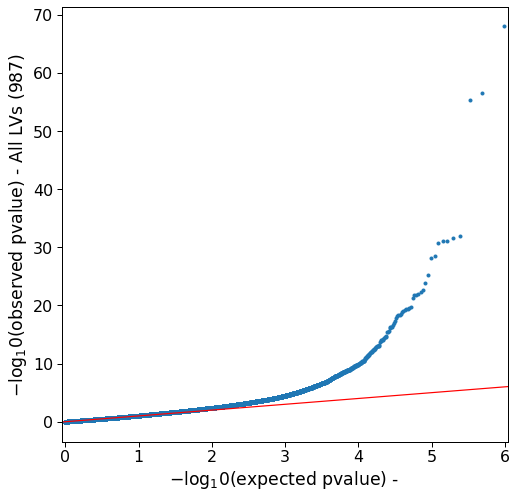

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.007,0.026,0.070
1,LV10,0.009,0.048,0.087
2,LV100,0.011,0.031,0.061
3,LV101,0.009,0.039,0.085
4,LV102,0.016,0.061,0.104


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.018366,0.062183,0.110993
std,0.018380,0.029134,0.036891
min,0.000000,0.000000,0.000000
25%,0.011000,0.047000,0.090000
50%,0.015000,0.059000,0.108000
75%,0.020000,0.070000,0.125000
max,0.254000,0.354000,0.413000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(65, 4)

,lv,1,5,10
451,LV505,0.013,0.049,0.096
878,LV890,0.010,0.049,0.092
838,LV854,0.009,0.049,0.095
829,LV846,0.009,0.049,0.108
797,LV817,0.011,0.049,0.094
791,LV811,0.009,0.049,0.100
724,LV751,0.014,0.049,0.095
584,LV625,0.008,0.049,0.104
500,LV55,0.009,0.049,0.090
496,LV546,0.010,0.049,0.089


,lv,1,5,10
932,LV939,0.012,0.051,0.099
908,LV917,0.017,0.051,0.097
893,LV903,0.010,0.051,0.094
222,LV3,0.013,0.051,0.107
267,LV34,0.012,0.051,0.098
825,LV842,0.011,0.051,0.091
49,LV143,0.019,0.051,0.093
470,LV522,0.015,0.051,0.095
707,LV736,0.013,0.051,0.098
361,LV424,0.011,0.051,0.089


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(457, 4)

,lv,1,5,10
403,LV462,0.060,0.153,0.246
906,LV915,0.089,0.161,0.218
129,LV215,0.082,0.170,0.235
349,LV413,0.102,0.176,0.232
153,LV237,0.091,0.177,0.253
255,LV329,0.133,0.183,0.211
423,LV480,0.099,0.193,0.295
682,LV713,0.108,0.196,0.252
401,LV460,0.112,0.196,0.260
965,LV969,0.117,0.201,0.272


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.017165,0.010307,1.665349,0.095892,0.047946,random.pheno988
1031,LV45,0.010681,0.010317,1.035250,0.300591,0.150295,random.pheno589
2018,LV45,0.005193,0.010315,0.503482,0.614643,0.307321,random.pheno385
3005,LV45,0.006474,0.010303,0.628327,0.529812,0.264906,random.pheno5
3992,LV45,-0.016331,0.010304,-1.584944,0.113028,0.943486,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.022

In [32]:
show_prop(results, 0.05)

0.064

In [33]:
show_prop(results, 0.10)

0.12

In [34]:
show_prop(results, 0.15)

0.164

In [35]:
show_prop(results, 0.20)

0.203

### QQplot

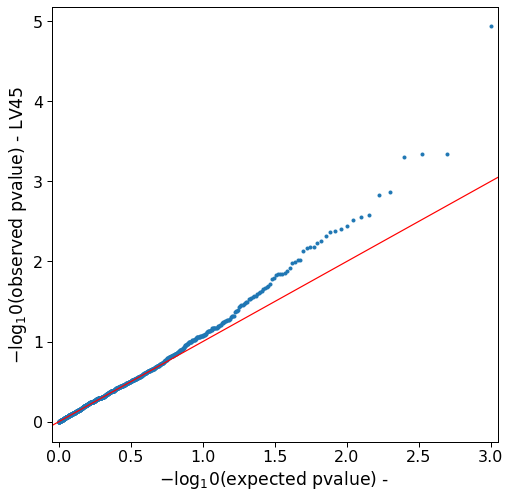

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.020108,0.012351,1.628008,0.103572,0.051786,random.pheno988
1220,LV234,0.000786,0.012337,0.063699,0.949212,0.474606,random.pheno589
2207,LV234,-0.012258,0.012329,-0.994243,0.320142,0.839929,random.pheno385
3194,LV234,0.009248,0.012328,0.750130,0.453204,0.226602,random.pheno5
4181,LV234,0.002661,0.012361,0.215271,0.829563,0.414782,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.018

In [43]:
show_prop(results, 0.05)

0.061

In [44]:
show_prop(results, 0.10)

0.119

In [45]:
show_prop(results, 0.15)

0.151

In [46]:
show_prop(results, 0.20)

0.178

### QQplot

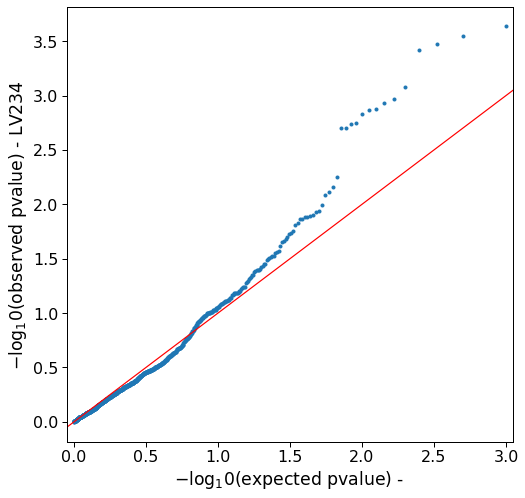

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.010204,0.012888,0.791727,0.428549,0.214275,random.pheno988
1833,LV847,0.003638,0.012915,0.281686,0.778193,0.389096,random.pheno589
2820,LV847,-0.014198,0.012896,-1.100931,0.270968,0.864516,random.pheno385
3807,LV847,0.007478,0.012879,0.580617,0.561519,0.280759,random.pheno5
4794,LV847,0.007949,0.012937,0.614396,0.538975,0.269488,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.024

In [54]:
show_prop(results, 0.05)

0.062

In [55]:
show_prop(results, 0.10)

0.104

In [56]:
show_prop(results, 0.15)

0.144

In [57]:
show_prop(results, 0.20)

0.192

### QQplot

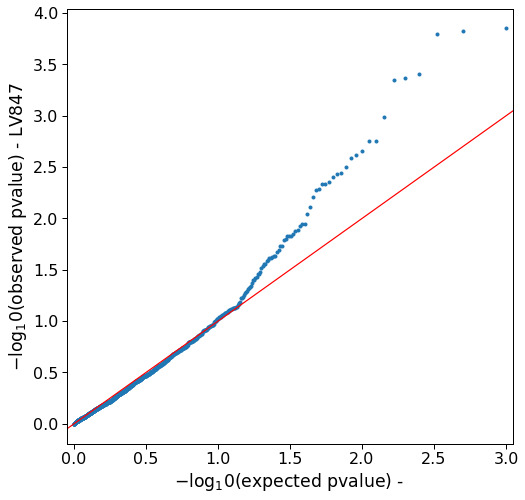

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.022750,0.013687,-1.662117,0.096538,0.951731,random.pheno988
1096,LV110,-0.009552,0.013701,-0.697161,0.485727,0.757136,random.pheno589
2083,LV110,-0.020323,0.013691,-1.484367,0.137761,0.931120,random.pheno385
3070,LV110,-0.009239,0.013654,-0.676633,0.498663,0.750668,random.pheno5
4057,LV110,-0.003474,0.013692,-0.253711,0.799727,0.600136,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.01

In [65]:
show_prop(results, 0.05)

0.035

In [66]:
show_prop(results, 0.10)

0.076

In [67]:
show_prop(results, 0.15)

0.112

In [68]:
show_prop(results, 0.20)

0.159

### QQplot

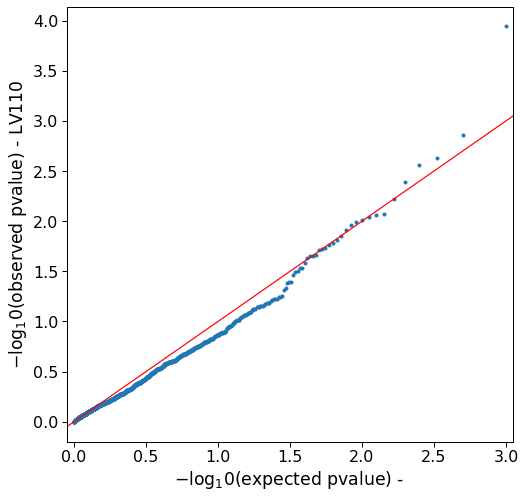

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.015497,0.011838,1.309072,0.190557,0.095278,random.pheno988
1755,LV769,0.002128,0.011804,0.180284,0.856935,0.428468,random.pheno589
2742,LV769,0.002791,0.011823,0.236107,0.813357,0.406678,random.pheno385
3729,LV769,-0.014473,0.011817,-1.224774,0.220705,0.889647,random.pheno5
4716,LV769,-0.019618,0.011843,-1.656553,0.097659,0.951171,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.054

In [76]:
show_prop(results, 0.05)

0.148

In [77]:
show_prop(results, 0.10)

0.23

In [78]:
show_prop(results, 0.15)

0.302

In [79]:
show_prop(results, 0.20)

0.355

### QQplot

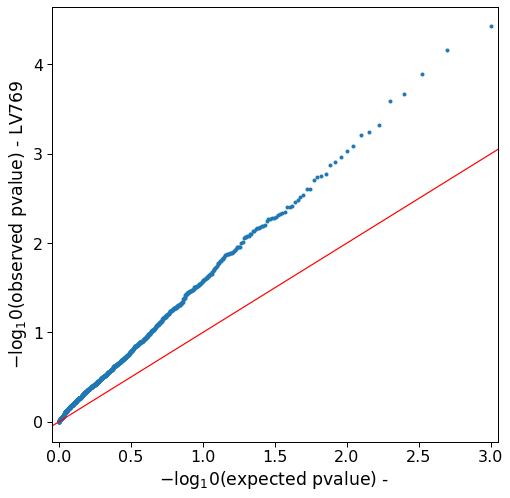

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.008132,0.014089,0.577196,0.563827,0.281914,random.pheno988
1786,LV800,-0.007031,0.014094,-0.498887,0.617876,0.691062,random.pheno589
2773,LV800,-0.003212,0.014115,-0.227560,0.819996,0.590002,random.pheno385
3760,LV800,-0.020696,0.014124,-1.465331,0.142880,0.928560,random.pheno5
4747,LV800,-0.012970,0.014065,-0.922183,0.356468,0.821766,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.01

In [87]:
show_prop(results, 0.05)

0.052

In [88]:
show_prop(results, 0.10)

0.093

In [89]:
show_prop(results, 0.15)

0.152

In [90]:
show_prop(results, 0.20)

0.193

### QQplot

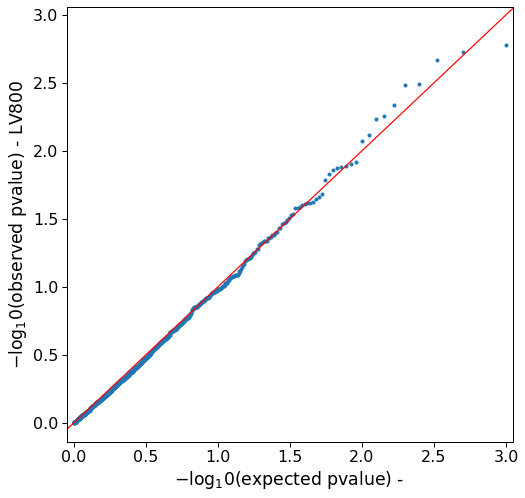

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
451,LV505,0.013,0.049,0.096
878,LV890,0.010,0.049,0.092
838,LV854,0.009,0.049,0.095
829,LV846,0.009,0.049,0.108
797,LV817,0.011,0.049,0.094
791,LV811,0.009,0.049,0.100
724,LV751,0.014,0.049,0.095
584,LV625,0.008,0.049,0.104
500,LV55,0.009,0.049,0.090
496,LV546,0.010,0.049,0.089


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.007436,0.011269,0.659869,0.509362,0.254681,random.pheno988
1398,LV412,-0.002828,0.011221,-0.252043,0.801016,0.599492,random.pheno589
2385,LV412,0.005820,0.011215,0.518903,0.603846,0.301923,random.pheno385
3372,LV412,0.003168,0.011278,0.280918,0.778782,0.389391,random.pheno5
4359,LV412,0.009430,0.011220,0.840444,0.400691,0.200345,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.011

In [100]:
show_prop(results, 0.05)

0.049

In [101]:
show_prop(results, 0.10)

0.091

In [102]:
show_prop(results, 0.15)

0.133

In [103]:
show_prop(results, 0.20)

0.164

### QQplot

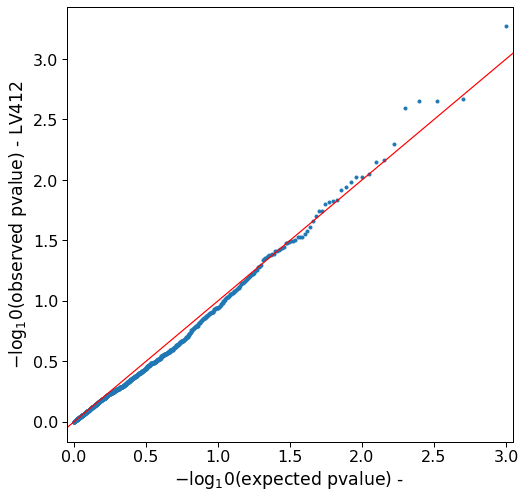

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.011945,0.012528,-0.953410,0.340418,0.829791,random.pheno988
1043,LV57,0.019503,0.012544,1.554764,0.120051,0.060026,random.pheno589
2030,LV57,0.017768,0.012551,1.415623,0.156934,0.078467,random.pheno385
3017,LV57,0.005420,0.012532,0.432478,0.665408,0.332704,random.pheno5
4004,LV57,0.012486,0.012511,0.997962,0.318335,0.159168,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.011

In [111]:
show_prop(results, 0.05)

0.055

In [112]:
show_prop(results, 0.10)

0.097

In [113]:
show_prop(results, 0.15)

0.134

In [114]:
show_prop(results, 0.20)

0.182

### QQplot

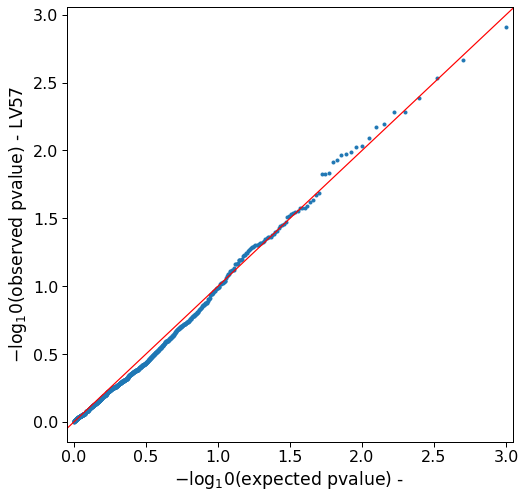

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.003317,0.011978,-0.276947,0.781829,0.609085,random.pheno988
1633,LV647,0.015069,0.011982,1.257613,0.208577,0.104289,random.pheno589
2620,LV647,0.008556,0.011982,0.714039,0.475229,0.237614,random.pheno385
3607,LV647,0.007840,0.011981,0.654347,0.512911,0.256456,random.pheno5
4594,LV647,0.010721,0.011954,0.896875,0.369819,0.184910,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.025

In [122]:
show_prop(results, 0.05)

0.072

In [123]:
show_prop(results, 0.10)

0.117

In [124]:
show_prop(results, 0.15)

0.148

In [125]:
show_prop(results, 0.20)

0.2

### QQplot

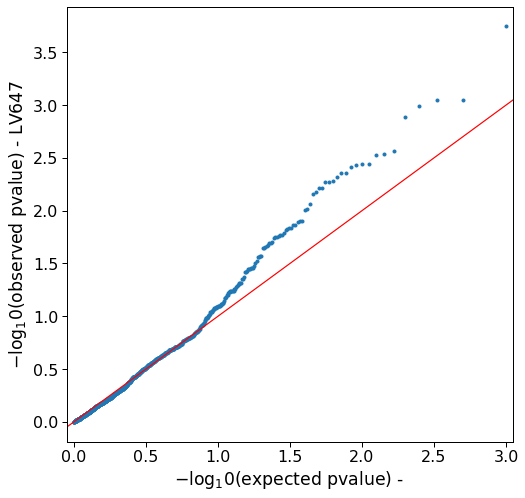

In [126]:
qqplot_unif(results)